# Outcome Prediction with RGAT Model

## 1. Load data from "processed_data" folder

In [1]:
import time
import joblib
import math
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.logging import log
from torch_geometric.nn import RGATConv
from torch_geometric.utils import to_undirected

In [2]:
num_patients = 1000
inverse_triples = True
embed_dim = 100
num_heads = 1

entity = pd.read_csv(f'processed_data/sphn_entities_{num_patients}_noOutcome.tsv', sep='\t', index_col=0, header=None)
entity = entity.to_dict()[1]

indices = []
for i in range(num_patients):
    idx = f'<http://nvasc.org/synth_patient_{i}>'
    indices.append(entity[idx])

events = pd.read_csv(f'processed_data/sphn_events_{num_patients}_noOutcome.tsv', sep='\t', header=None)
y = joblib.load(f'../Data Generation/outcomes_{num_patients}_0.joblib')

non_test_X, test_X, non_test_y, test_y_ = train_test_split(indices, y, stratify=y, test_size=0.2)
train_X, valid_X, train_y_, valid_y_ = train_test_split(non_test_X, non_test_y, stratify=non_test_y, test_size=1./8)

edge_index = torch.vstack((torch.Tensor(events[0]).long(),torch.Tensor(events[2]).long()))
edge_type = torch.Tensor(events[1]).long()
train_idx = torch.Tensor(train_X).long()
train_y = torch.Tensor(train_y_).long()
valid_idx = torch.Tensor(valid_X).long()
valid_y = torch.Tensor(valid_y_).long()
test_idx = torch.Tensor(test_X).long()
test_y = torch.Tensor(test_y_).long()
num_nodes = len(entity)

if inverse_triples == True:
    edge_index = to_undirected(edge_index)
    edge_type = torch.cat((edge_type, edge_type))

data = Data(
    edge_index=edge_index,
    edge_type=edge_type,
    train_idx=train_idx,
    train_y=train_y,
    valid_idx=valid_idx,
    valid_y=valid_y,
    test_idx=test_idx,
    test_y=test_y,
    num_nodes=num_nodes,
)
embedding = torch.nn.Parameter(torch.empty(num_nodes, embed_dim))
torch.nn.init.xavier_uniform_(embedding, gain=math.sqrt(2.0))
data.x = embedding
data.num_relations = data.num_edge_types
data.num_classes = 3
print(data)

Data(edge_index=[2, 221870], edge_type=[221870], train_idx=[700], train_y=[700], valid_idx=[100], valid_y=[100], test_idx=[200], test_y=[200], num_nodes=33563, x=[33563, 100], num_relations=10, num_classes=3)


## 2. Training the model

In [3]:
class RGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_relations):
        super().__init__()
        self.conv1 = RGATConv(in_channels, hidden_channels, num_relations, heads=num_heads)
        self.conv2 = RGATConv(hidden_channels*num_heads, out_channels, num_relations, heads=num_heads)
        # self.lin = torch.nn.Linear(hidden_channels*num_heads, out_channels)

    def forward(self, x, edge_index, edge_type):
        x = F.elu(self.conv1(x, edge_index, edge_type))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        # x = self.lin(x)
        return F.log_softmax(x, dim=-1)


if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model = RGAT(embed_dim, 16, data.num_classes, data.num_relations).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

In [4]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_type)
    loss = F.nll_loss(out[data.train_idx], data.train_y)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_type).argmax(dim=-1)
    train_acc = float((pred[data.train_idx] == data.train_y).float().mean())
    val_acc = float((pred[data.valid_idx] == data.valid_y).float().mean())
    test_acc = float((pred[data.test_idx] == data.test_y).float().mean())
    return train_acc, val_acc, test_acc

In [5]:
times = []
best_val_acc = final_test_acc = 0
for epoch in range(1, 1001):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
        torch.save(model.state_dict(), f'processed_data/model_weights_rgcn_{num_patients}.pth')
    log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 001, Loss: 1.0986, Train: 0.4257, Val: 0.3700, Test: 0.4400
Epoch: 002, Loss: 1.0889, Train: 0.4386, Val: 0.4000, Test: 0.4650
Epoch: 003, Loss: 1.0788, Train: 0.4386, Val: 0.3700, Test: 0.4650
Epoch: 004, Loss: 1.0684, Train: 0.4271, Val: 0.3600, Test: 0.4650
Epoch: 005, Loss: 1.0572, Train: 0.4300, Val: 0.3900, Test: 0.4650
Epoch: 006, Loss: 1.0456, Train: 0.4329, Val: 0.3800, Test: 0.4650
Epoch: 007, Loss: 1.0349, Train: 0.4257, Val: 0.3800, Test: 0.4650
Epoch: 008, Loss: 1.0238, Train: 0.4229, Val: 0.4100, Test: 0.4350
Epoch: 009, Loss: 1.0128, Train: 0.4257, Val: 0.4100, Test: 0.4350
Epoch: 010, Loss: 1.0055, Train: 0.4243, Val: 0.4200, Test: 0.4200
Epoch: 011, Loss: 0.9965, Train: 0.4257, Val: 0.4200, Test: 0.4200
Epoch: 012, Loss: 0.9892, Train: 0.4271, Val: 0.4200, Test: 0.4200
Epoch: 013, Loss: 0.9839, Train: 0.4271, Val: 0.4100, Test: 0.4200
Epoch: 014, Loss: 0.9800, Train: 0.4471, Val: 0.3900, Test: 0.4200
Epoch: 015, Loss: 0.9790, Train: 0.4429, Val: 0.3900, Test: 0.

In [6]:
from sklearn.metrics import roc_auc_score

model = RGAT(embed_dim, 16, data.num_classes, data.num_relations).to(device)
model.load_state_dict(torch.load(f'processed_data/model_weights_rgcn_{num_patients}.pth', weights_only=True))
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index, data.edge_type).cpu()
    prob = F.softmax(out, dim=1)
auc = roc_auc_score(data.test_y.cpu(), prob[data.test_idx.cpu()], multi_class='ovr')
print(f'ROC AUC score: {auc:.4f}')
# print(prob.shape)

ROC AUC score: 0.5438


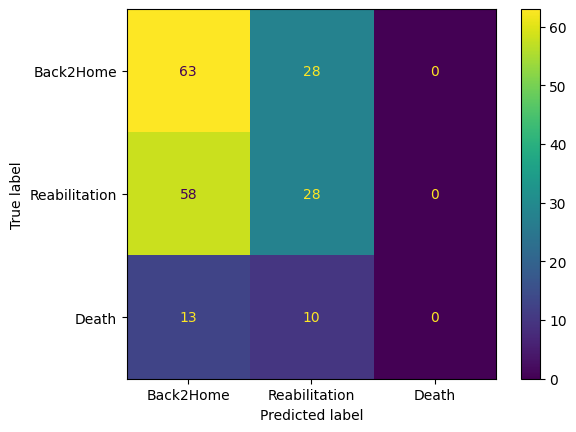

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
pred = model(data.x, data.edge_index, data.edge_type).argmax(dim=-1)
matrix = confusion_matrix(data.test_y.cpu(), pred[data.test_idx].cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Back2Home", "Reabilitation", "Death"])
disp.plot()
plt.show()